In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D, UpSampling1D
from keras.optimizers import Adam, RMSprop, SGD
from sklearn.cross_validation import KFold
import matplotlib.cm as cm
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.cross_validation import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import scipy.io

Using TensorFlow backend.
/Users/Nikos/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Setting the random seeds
random.seed(1)
np.random.seed(1337)

In [3]:
def load_data(filepath):

# Description: This function is responsible for loading our data.
# Args in: filepath - the path of the .mat file containing the data
# Returns: inputs - the data, labels - the labels corresponding to the data, 
#            patients - the patients corresponding to the data

    mat = scipy.io.loadmat(filepath)
    inputs = mat['U0_new'][:]
    labels = mat['Y']
    patients = mat['patientID']

    labels = np.einsum('ij->ji', labels)
    labels = [label for sublist in labels for label in sublist]
    patients = np.einsum('ij->ji', patients)
    patients = [patient for sublist in patients for patient in sublist]

    return inputs, labels, patients

In [4]:
def filter_duplicates(duplicates_list, inputs, targets, patients):

# Description: This function is responsible for filtering out
# some patients that are found to be present in more than one classes.
# Args in & Returns are self-explanatory.
    
    patients = list(patients)
    
    duplicate_indices = []
    for duplicate in duplicates_list:
        #patients = list(filter(lambda a: a != duplicate, patients))
        for i in range(len(patients)):
            if patients[i] == duplicate:
                duplicate_indices.append(i)
    
    duplicate_indices = set(duplicate_indices)
    all_indices = set([i for i in range(len(patients))])
    valid_indices = set(all_indices - duplicate_indices)
    inputs = [inputs[i] for i in valid_indices]
    targets = [targets[i] for i in valid_indices]
    patients = [patients[i] for i in valid_indices]
    
    return inputs, targets, np.asarray(patients)

In [5]:
inputs, labels, patients = load_data('/Users/Nikos/Desktop/MyResearch/Zacharaki/PARAFACmissingvalues0_90/ReconstructedTensorAndFeatures90Missing_StrSGD.mat')

In [6]:
inputs, labels, patients = filter_duplicates([1002, 1104], inputs, labels, patients)

In [7]:
def split_train_test(inputs, targets, patients, patients_for_test):

# Description: This function is responsible for splitting our data into training and test data
# Args in: patients_for_val - list containing the patients for our test data
# Returns: the data and labels of our training and test data

    X_train_size = X_test_size = 0

    patients_for_train = [item for item in list(np.unique(patients)) if item not in patients_for_test]
    idpatients_test = []
    for patient in patients_for_test:
        idpatient = [i for i, x in enumerate(patients) if x == patient]
        idpatients_test.append(idpatient)
    idpatients_test = [item for sublist in idpatients_test for item in sublist]
    X_test = [inputs[i] for i in idpatients_test]
    y_test = [targets[i] for i in idpatients_test]
    patients_test = [patients[i] for i in idpatients_test]
    
    #print(inputs.shape)
    idpatients_train = list(set([i for i in range(inputs.shape[0])]) - set(idpatients_test))
    #print(idpatients_train)
    inputs = [inputs[i] for i in idpatients_train]
    targets = [targets[i] for i in idpatients_train]
    patients_train = [patients[i] for i in idpatients_train]
    
    return np.asarray(inputs), np.asarray(targets), np.asarray(patients_train), np.asarray(X_test), np.asarray(y_test), np.asarray(patients_test)

def split_train_val(inputs, targets, patients, patients_for_val):

# Description: This function is responsible for splitting our data into training and validation data
# Args in: patients_for_val - list containing the patients for our validation data
# Returns: the data and labels of our training and validation data

    X_train_size = X_val_size = 0

    patients_for_train = [item for item in list(np.unique(patients)) if item not in patients_for_val]
    idpatients_val = []
    for patient in patients_for_val:
        idpatient = [i-1 for i, x in enumerate(patients) if x == patient]
        idpatients_val.append(idpatient)
    idpatients_val = [item for sublist in idpatients_val for item in sublist]
    X_val = [inputs[i] for i in idpatients_val]
    y_val = [targets[i] for i in idpatients_val]
    
    idpatients_train = list(set([i for i in range(inputs.shape[0])]) - set(idpatients_val))
    inputs = [inputs[i] for i in idpatients_train]
    y_train = [targets[i] for i in idpatients_train]

    return np.asarray(inputs), np.asarray(X_val), np.asarray(inputs), np.asarray(X_val), np.asarray(y_train), np.asarray(y_val)

In [8]:
print(np.unique(patients))

[1003 1005 1006 1007 1012 1013 1017 1027 1035 1042 1044 1047 1049 1050 1052
 1053 1054 1056 1057 1059 1063 1086 1090 1091 1092 1093 1094 1095 1098 1099
 1100 1101 1102 1103 1106 1107 1108 1109 1110 1113 1114 1115 1118 1119 1120
 1510 1514 1558 2005 2006 2050 2057 2070 2073 2081 2082 2083 2085 2087 2089
 2090 2091 2092 2094 2095 2097 2098 2100 2101 2102 2103 2104 2105 2107 2108
 2109 2110 2111 2113 2116 2119 2584 2615 3006 3026 3033 3034 3035 3039 3043
 3052 3062 3070 3076 3082 3084 3085 3086 3087 3095 3098 3099 3104 3106 3112
 3113 3117 3525 3550 3559 3578 3592 3593 3601]


In [9]:
inputs = np.asarray(inputs)
labels = np.asarray(labels)
X_train, y_train, patients_train, X_test, y_test, patients_test = split_train_test(inputs, labels, patients, [1106, 1107, 2097])
X_train, X_val, train_ground, valid_ground, y_train, y_val = split_train_val(X_train, y_train, patients_train, [1006, 3026, 2104])
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)
print(np.unique(y_train), np.unique(y_val), np.unique(y_test))

(16556, 60) (16556,) (1393, 60) (1393,) (333, 60) (333,)
[0 1 2] [0 1 2] [0 1 2]


In [27]:
from sklearn.preprocessing import StandardScaler
def preprocess_data(X_train, X_val, X_test):

# Description: This function preprocesses our data. 
# We want to ensure that our training data have zero mean and unit variance. 
# We also use subtract the same mean from the test data and then devide them by
# the same standard deviation. We do that to ensure that no information about the
# test set distribution is known ahead of time.

# Args in & Returns are self-explanatory.
    scalers = {}
    scaler = StandardScaler()
    """
    for i in range(X_train.shape[2]):
        scalers[i] = StandardScaler()
        X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :])
    
    for i in range(X_test.shape[2]):
        X_val[:, i, :] = scalers[i].transform(X_val[:, i, :]) 
        
    for i in range(X_test.shape[2]):
        X_test[:, i, :] = scalers[i].transform(X_test[:, i, :]) 
    """
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    #X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis = 0)
    
    #X_val = (X_val - np.mean(X_train, axis=0)) / np.std(X_train, axis = 0)
    
    #X_test = (X_test -  np.mean(X_train, axis=0)) / np.std(X_train, axis = 0)
    
    #X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1] * X_test.shape[2]))
    #X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
    #X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1] * X_val.shape[2]))
    
    return X_train, X_val, X_train, X_val, X_test

In [28]:
X_train, X_val, train_ground, valid_ground, X_test = preprocess_data(X_train, X_val, X_test)

In [29]:
print(X_train.shape, X_val.shape, X_test.shape)
adam = Adam(lr = 0.01)

(16556, 60) (333, 60) (1393, 60)


In [30]:
learning_rates = [1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001]

input_signal = Input(shape = (X_train.shape[1],))
encoded = Dense(32, activation = 'relu')(input_signal)

# decoder
#decoded = Dense(1500*7, activation = 'sigmoid')(encoded)
decoded = Dense(60, activation = 'sigmoid')(encoded)

autoencoder = Model(input = input_signal, output = decoded)

encoder = Model(input = input_signal, output = encoded)
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

for lr in learning_rates:
    adam = Adam(lr = lr)
    autoencoder.compile(loss="mean_squared_error", optimizer=adam, metrics=['mse'])
    hist = autoencoder.fit(X_train, X_train, epochs=20, batch_size=128, 
                                    validation_data=(X_val, X_val), verbose=0, shuffle=True)
    print(lr, hist.history['val_loss'][-1])

/Users/Nikos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.
/Users/Nikos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if sys.path[0] == '':


1.0 0.972964170101
0.3 0.971647263826
0.1 0.971041842087
0.03 0.9708646015
0.01 0.970924052569
0.003 0.970924052569
0.001 0.970924052569
0.0003 0.970924052569
0.0001 0.970924052569
3e-05 0.970924052569
1e-05 0.970924052569


In [31]:
adam = Adam(0.03)
autoencoder.compile(loss="mean_squared_error", optimizer=adam, metrics=['mse'])
print(autoencoder.summary())
history = autoencoder.fit(X_train, train_ground, epochs=100, batch_size=128, 
                                    validation_data=(X_val, valid_ground), verbose=0, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 60)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                1952      
_________________________________________________________________
dense_23 (Dense)             (None, 60)                1980      
Total params: 3,932
Trainable params: 3,932
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
encoder_X_train = encoder.predict(X_train)
encoder_X_test = [encoder.predict(X_test), encoder.predict(X_val)]
encoder_X_test = [i for sublist in encoder_X_test for i in sublist]

y_test = [y_test, y_val]
y_test = [i for sublist in y_test for i in sublist]
y_test = np.asarray(y_test)

print(np.unique(y_test))
print(np.unique(y_train))

encoder_X_train = np.asarray(encoder_X_train)
encoder_X_test = np.asarray(encoder_X_test)

print(encoder_X_train.shape)
print(encoder_X_test.shape)

[0 1 2]
[0 1 2]
(16556, 32)
(1726, 32)


In [33]:
c = list(zip(encoder_X_train, y_train))
random.shuffle(c)
encoder_X_train, y_train = zip(*c)

c = list(zip(encoder_X_test, y_test))
random.shuffle(c)
encoder_X_test, y_test = zip(*c)

encoder_X_train = np.asarray(encoder_X_train)
encoder_X_test = np.asarray(encoder_X_test)

In [21]:
def one_hot(labels, n_class = 6):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = []
    for i in labels:
        y.append(expansion[int(i)])
    y = np.asarray(y)

    return y

In [17]:
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import keras.backend as K
#from sklearn.metrics import balanced_accuracy_score

class BalancedAccuracy(Callback):
    def __init__(self, train_data, validation_data):
        super(BalancedAccuracy, self).__init__()
        self.acas = []
        self.validation_data = validation_data
        self.train_data = train_data
        
    def on_epoch_end(self, epoch, logs={}):

        X_val = self.validation_data[0]
        y_val = self.validation_data[1]

        X_train = self.train_data[0]
        y_train = self.train_data[1]

        y_val_pred = self.model.predict(X_val)
        y_train_pred = self.model.predict(X_train)

        val_score = self.eval_avg_class_acc(y_val, y_val_pred)
        
        print("\nBalanced Accuracy - val: %.3f"%(val_score))        
        
    def eval_avg_class_acc(self, y_true, y_pred):

        # decode one-hot to single labels
        y_pred = y_pred.round()
        y_pred = [ np.argmax(pred, axis = 0) for pred in y_pred ]
        y_true = [ np.argmax(label, axis = 0) for label in y_true ]

        cf = confusion_matrix(y_true, y_pred)

        class0_acc = float(cf[0][0]) / (float(cf[0][0]) + float(cf[0][1]) + float(cf[0][2]))
        class1_acc = float(cf[1][1]) / (float(cf[1][1]) + float(cf[1][0]) + float(cf[1][2]))
        class2_acc = float(cf[2][2]) / (float(cf[2][2]) + float(cf[2][0]) + float(cf[2][1]))
        balanced_acc = float((class0_acc + class1_acc + class2_acc) / 3)

        return balanced_acc

def weighted_categorical_crossentropy(y_true, y_pred, weights):
    
    weights = K.variable(weights)
        
    # scale predictions so that the class probas of each sample sum to 1
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    # clip to prevent NaN's and Inf's
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # calc
    loss = y_true * K.log(y_pred) * weights
    loss = -K.sum(loss, -1)
    return loss

In [18]:
from functools import partial

# Weighted loss function to tackle class imbalance in the dataset
#weights = np.array([1, 1, 1.2])
weights = np.array([float(len(y_train)) / float(list(y_train).count(0)), float(len(y_train)) / float(list(y_train).count(1)), 0.8 * float(len(y_train)) / float(list(y_train).count(2))])
w_cat_crossentropy = partial(weighted_categorical_crossentropy, weights = weights)
w_cat_crossentropy.__name__ = 'weighted_categorical_crossentropy'
        
balanced_accuracy = BalancedAccuracy(train_data = (encoder_X_train, y_train), validation_data = (encoder_X_test, y_test))
CALLBACKS = [balanced_accuracy]

In [56]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.layers import Activation, BatchNormalization
from keras.layers import Dropout
import tensorflow as tf
from keras.optimizers import Adamax

model = Sequential()
#model.add(Dense(256, kernel_initializer='random_uniform', input_shape = (32,)))
#model.add(Activation('relu'))
#model.add(BatchNormalization())
#model.add(Dense(128, kernel_initializer='random_uniform'))
#model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(Dense(128, kernel_initializer='random_uniform', input_shape = (32,)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dense(3))
model.add(Activation(tf.nn.softmax))

opt = Adam(lr = 0.001)
y_train_one_hot = one_hot(y_train, 3)
y_test_one_hot = one_hot(y_test, 3)

model.compile(loss=w_cat_crossentropy, optimizer=opt, metrics=['accuracy'])

history = model.fit(encoder_X_train, y_train_one_hot, epochs=100, batch_size=512, validation_data=(encoder_X_test, y_test_one_hot), 
          verbose=2, shuffle=True, callbacks=CALLBACKS)

Train on 16556 samples, validate on 1726 samples
Epoch 1/100
 - 4s - loss: 3.2834 - acc: 0.4703 - val_loss: 7.0087 - val_acc: 0.3969

Balanced Accuracy - val: 0.345
Epoch 2/100
 - 0s - loss: 2.7007 - acc: 0.5534 - val_loss: 6.8476 - val_acc: 0.4009

Balanced Accuracy - val: 0.357
Epoch 3/100
 - 0s - loss: 2.5723 - acc: 0.5853 - val_loss: 6.8971 - val_acc: 0.3859

Balanced Accuracy - val: 0.374
Epoch 4/100
 - 0s - loss: 2.5047 - acc: 0.5993 - val_loss: 7.2290 - val_acc: 0.3482

Balanced Accuracy - val: 0.399
Epoch 5/100
 - 0s - loss: 2.4432 - acc: 0.6116 - val_loss: 7.1684 - val_acc: 0.3778

Balanced Accuracy - val: 0.389
Epoch 6/100
 - 0s - loss: 2.4027 - acc: 0.6176 - val_loss: 6.7368 - val_acc: 0.3685

Balanced Accuracy - val: 0.397
Epoch 7/100
 - 0s - loss: 2.3587 - acc: 0.6258 - val_loss: 6.9337 - val_acc: 0.3528

Balanced Accuracy - val: 0.412
Epoch 8/100
 - 0s - loss: 2.3338 - acc: 0.6300 - val_loss: 7.2661 - val_acc: 0.3783

Balanced Accuracy - val: 0.412
Epoch 9/100
 - 0s - los


Balanced Accuracy - val: 0.417
Epoch 71/100
 - 0s - loss: 1.7460 - acc: 0.7151 - val_loss: 10.7486 - val_acc: 0.3598

Balanced Accuracy - val: 0.405
Epoch 72/100
 - 0s - loss: 1.7563 - acc: 0.7090 - val_loss: 10.2636 - val_acc: 0.3413

Balanced Accuracy - val: 0.386
Epoch 73/100
 - 0s - loss: 1.7612 - acc: 0.7110 - val_loss: 9.9441 - val_acc: 0.3824

Balanced Accuracy - val: 0.419
Epoch 74/100
 - 0s - loss: 1.7412 - acc: 0.7183 - val_loss: 9.8895 - val_acc: 0.3650

Balanced Accuracy - val: 0.417
Epoch 75/100
 - 0s - loss: 1.7378 - acc: 0.7130 - val_loss: 10.4820 - val_acc: 0.3546

Balanced Accuracy - val: 0.403
Epoch 76/100
 - 0s - loss: 1.7374 - acc: 0.7176 - val_loss: 10.1760 - val_acc: 0.3737

Balanced Accuracy - val: 0.416
Epoch 77/100
 - 0s - loss: 1.7396 - acc: 0.7148 - val_loss: 10.2682 - val_acc: 0.3621

Balanced Accuracy - val: 0.415
Epoch 78/100
 - 0s - loss: 1.7285 - acc: 0.7183 - val_loss: 9.1468 - val_acc: 0.3859

Balanced Accuracy - val: 0.426
Epoch 79/100
 - 0s - loss: 

In [23]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

0.720403479274


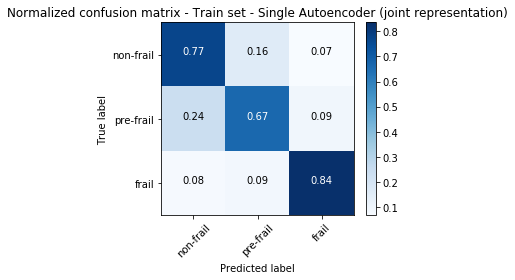

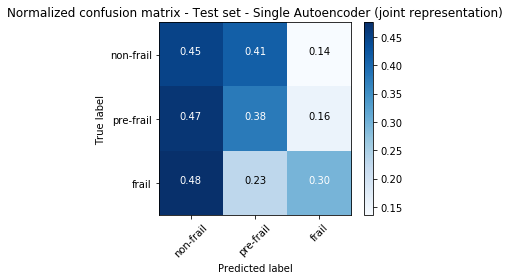

In [59]:
print(history.history["acc"][-1])

# TRAIN SET
preds = model.predict(encoder_X_train)

# decode one-hot to single labels
preds = [ np.argmax(pred, axis = 0) for pred in preds ]
labels = [ np.argmax(label, axis = 0) for label in y_train_one_hot ]

# Compute confusion matrix
cnf_matrix = confusion_matrix(labels, preds)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["non-frail", "pre-frail", "frail"], normalize=True,
                      title='Normalized confusion matrix - Train set - Single Autoencoder (joint representation)')

# TEST SET
preds = model.predict(encoder_X_test)

# decode one-hot to single labels
preds = [ np.argmax(pred, axis = 0) for pred in preds ]
labels = [ np.argmax(label, axis = 0) for label in y_test_one_hot ]

# Compute confusion matrix
cnf_matrix = confusion_matrix(labels, preds)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["non-frail", "pre-frail", "frail"], normalize=True,
                      title='Normalized confusion matrix - Test set - Single Autoencoder (joint representation)')

plt.show()